## Imports

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Utility

In [61]:
def show_image(batch_of_tensors):
    images = batch_of_tensors[:4]
    images = (images * 0.5) + 0.5  # Unnormalize the images to [0, 1] range
    grid_img = torchvision.utils.make_grid(images, nrow=2)
    plt.figure(figsize=(5, 5))
    plt.imshow(grid_img.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.axis('off')
    plt.show()

## Hyperparameters

In [69]:
# batch_size = 128
# learning_rate = 1e-3
# num_epochs = 50
# image_size = 32
# channels = 3
# latent_dim = 128
# num_embeddings = 512  # Number of vectors in the codebook
# commitment_cost = 0.25  # Beta, the commitment loss weight

batch_size = 256
learning_rate = 1e-3
num_epochs = 100
image_size = 32  # Keep same for CIFAR-10
channels = 3     # Keep same for CIFAR-10
latent_dim = 256
num_embeddings = 2048
commitment_cost = 0.01  # Keep this initially, adjust based on results

## Dataset

In [70]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


## Vector Quantised Embedding

In [71]:
class VQEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)

    def forward(self, z):
        b, c, h, w = z.shape
        z_channel_last = z.permute(0, 2, 3, 1)
        z_flattened = z_channel_last.reshape(b*h*w, self.embedding_dim)

        # Calculate distances between z and the codebook embeddings |a-b|²
        distances = (
            torch.sum(z_flattened ** 2, dim=-1, keepdim=True)                 # a²
            + torch.sum(self.embedding.weight.t() ** 2, dim=0, keepdim=True)  # b²
            - 2 * torch.matmul(z_flattened, self.embedding.weight.t())        # -2ab
        )

        # Get the index with the smallest distance
        encoding_indices = torch.argmin(distances, dim=-1)

        # Get the quantized vector
        z_q = self.embedding(encoding_indices)
        z_q = z_q.reshape(b, h, w, self.embedding_dim)
        z_q = z_q.permute(0, 3, 1, 2)

        # Calculate the commitment loss
        loss = F.mse_loss(z_q, z.detach()) + commitment_cost * F.mse_loss(z_q.detach(), z)

        # Straight-through estimator trick for gradient backpropagation
        z_q = z + (z_q - z).detach()

        return z_q, loss, encoding_indices

## Vector Quantised Variational Autoencoder Model

In [72]:
class VQVAE(nn.Module):
    def __init__(self):
        super(VQVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, latent_dim, kernel_size=1)
        )

        # Vector Quantization
        self.vq_layer = VQEmbedding(num_embeddings, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, kernel_size=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output values in range [-1, 1]
        )

    def forward(self, x):
        z_e = self.encoder(x)
        z_q, vq_loss, _ = self.vq_layer(z_e)
        x_recon = self.decoder(z_q)
        return x_recon, vq_loss

## Loss function

In [73]:
def vqvae_loss(recon_x, x, vq_loss):
    recon_loss = F.mse_loss(recon_x, x)
    return recon_loss + vq_loss

## Training

In [74]:
model = VQVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=num_epochs,  # Total number of epochs
    eta_min=1e-6      # Minimum learning rate
)

# # Visualize learning rate schedule
# import matplotlib.pyplot as plt

# lrs = []
# for _ in range(num_epochs):
#     lrs.append(optimizer.param_groups[0]['lr'])
#     scheduler.step()

# plt.plot(lrs)
# plt.title('Learning Rate Schedule')
# plt.xlabel('Epoch')
# plt.ylabel('Learning Rate')
# plt.show()

# # Reset scheduler
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

Epoch 1/100: 100%|██████████| 196/196 [00:14<00:00, 13.98it/s, Loss=15.9019, LR=0.001000]


Epoch [1/100] Average Loss: 2.7004 LR: 0.001000


Epoch 2/100: 100%|██████████| 196/196 [00:14<00:00, 13.89it/s, Loss=185.4944, LR=0.001000]


Epoch [2/100] Average Loss: 0.3621 LR: 0.001000


Epoch 3/100: 100%|██████████| 196/196 [00:13<00:00, 14.13it/s, Loss=30.7521, LR=0.000999]


Epoch [3/100] Average Loss: 0.3789 LR: 0.000999


Epoch 4/100: 100%|██████████| 196/196 [00:14<00:00, 13.75it/s, Loss=15.6976, LR=0.000998]


Epoch [4/100] Average Loss: 0.0949 LR: 0.000998


Epoch 5/100: 100%|██████████| 196/196 [00:14<00:00, 13.84it/s, Loss=5.7766, LR=0.000996]


Epoch [5/100] Average Loss: 0.0393 LR: 0.000996


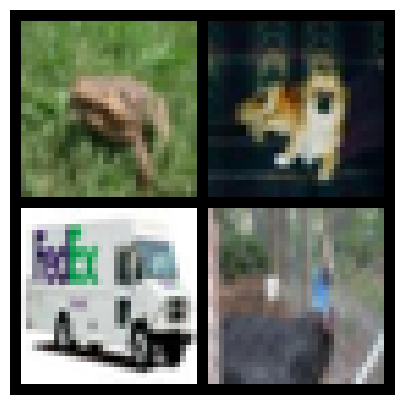

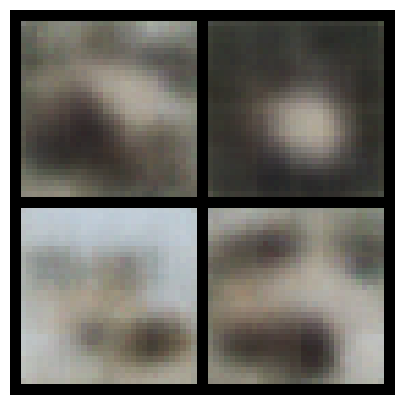

Epoch 6/100: 100%|██████████| 196/196 [00:14<00:00, 13.90it/s, Loss=2.8523, LR=0.000994]


Epoch [6/100] Average Loss: 0.0169 LR: 0.000994


Epoch 7/100: 100%|██████████| 196/196 [00:14<00:00, 13.95it/s, Loss=2.3919, LR=0.000991]


Epoch [7/100] Average Loss: 0.0103 LR: 0.000991


Epoch 8/100: 100%|██████████| 196/196 [00:13<00:00, 14.08it/s, Loss=2.1057, LR=0.000988]


Epoch [8/100] Average Loss: 0.0082 LR: 0.000988


Epoch 9/100: 100%|██████████| 196/196 [00:13<00:00, 14.05it/s, Loss=2.7520, LR=0.000984]


Epoch [9/100] Average Loss: 0.0093 LR: 0.000984


Epoch 10/100: 100%|██████████| 196/196 [00:13<00:00, 14.01it/s, Loss=2.0133, LR=0.000980]


Epoch [10/100] Average Loss: 0.0091 LR: 0.000980


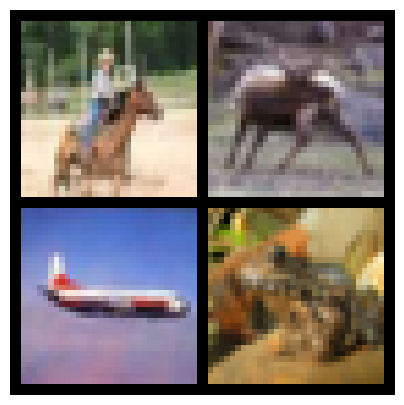

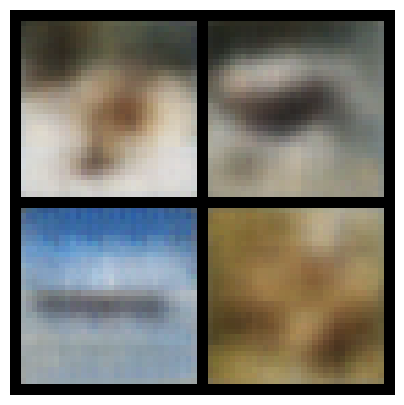

Epoch 11/100: 100%|██████████| 196/196 [00:13<00:00, 14.13it/s, Loss=1.8377, LR=0.000976]


Epoch [11/100] Average Loss: 0.0076 LR: 0.000976


Epoch 12/100: 100%|██████████| 196/196 [00:13<00:00, 14.12it/s, Loss=1.5709, LR=0.000970]


Epoch [12/100] Average Loss: 0.0068 LR: 0.000970


Epoch 13/100: 100%|██████████| 196/196 [00:14<00:00, 13.94it/s, Loss=1.6314, LR=0.000965]


Epoch [13/100] Average Loss: 0.0063 LR: 0.000965


Epoch 14/100: 100%|██████████| 196/196 [00:14<00:00, 13.96it/s, Loss=1.4710, LR=0.000959]


Epoch [14/100] Average Loss: 0.0060 LR: 0.000959


Epoch 15/100: 100%|██████████| 196/196 [00:13<00:00, 14.03it/s, Loss=1.4702, LR=0.000952]


Epoch [15/100] Average Loss: 0.0058 LR: 0.000952


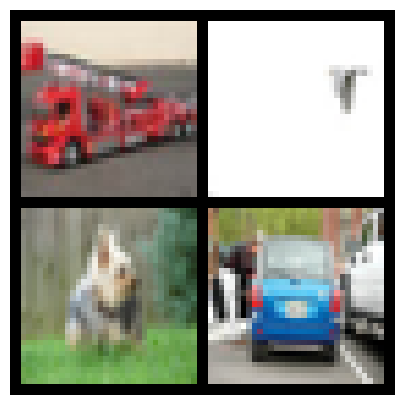

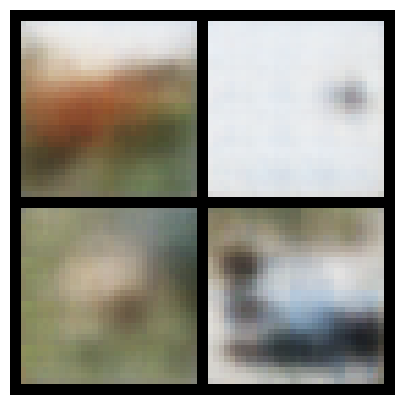

Epoch 16/100: 100%|██████████| 196/196 [00:14<00:00, 13.96it/s, Loss=1.3413, LR=0.000946]


Epoch [16/100] Average Loss: 0.0057 LR: 0.000946


Epoch 17/100: 100%|██████████| 196/196 [00:14<00:00, 13.91it/s, Loss=1.4512, LR=0.000938]


Epoch [17/100] Average Loss: 0.0056 LR: 0.000938


Epoch 18/100: 100%|██████████| 196/196 [00:14<00:00, 13.90it/s, Loss=1.3892, LR=0.000930]


Epoch [18/100] Average Loss: 0.0055 LR: 0.000930


Epoch 19/100: 100%|██████████| 196/196 [00:13<00:00, 14.07it/s, Loss=1.3024, LR=0.000922]


Epoch [19/100] Average Loss: 0.0054 LR: 0.000922


Epoch 20/100: 100%|██████████| 196/196 [00:14<00:00, 13.98it/s, Loss=1.4581, LR=0.000914]


Epoch [20/100] Average Loss: 0.0053 LR: 0.000914


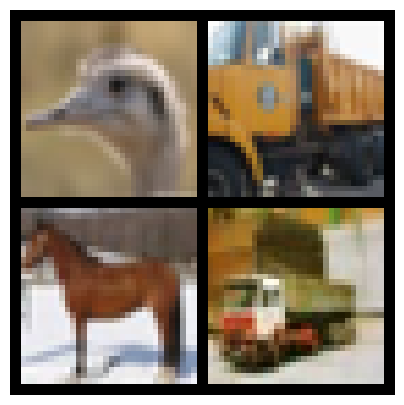

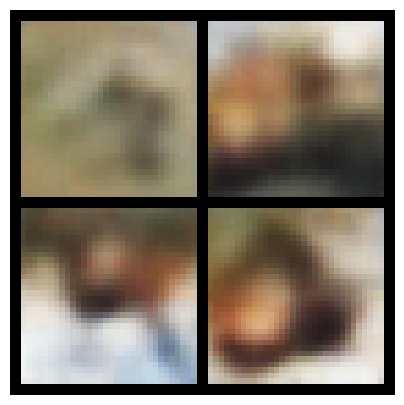

Epoch 21/100: 100%|██████████| 196/196 [00:14<00:00, 13.87it/s, Loss=1.2822, LR=0.000905]


Epoch [21/100] Average Loss: 0.0052 LR: 0.000905


Epoch 22/100: 100%|██████████| 196/196 [00:14<00:00, 13.84it/s, Loss=1.3635, LR=0.000895]


Epoch [22/100] Average Loss: 0.0051 LR: 0.000895


Epoch 23/100: 100%|██████████| 196/196 [00:14<00:00, 13.96it/s, Loss=1.3401, LR=0.000885]


Epoch [23/100] Average Loss: 0.0051 LR: 0.000885


Epoch 24/100: 100%|██████████| 196/196 [00:14<00:00, 13.90it/s, Loss=1.4024, LR=0.000875]


Epoch [24/100] Average Loss: 0.0051 LR: 0.000875


Epoch 25/100: 100%|██████████| 196/196 [00:14<00:00, 13.94it/s, Loss=1.2234, LR=0.000865]


Epoch [25/100] Average Loss: 0.0051 LR: 0.000865


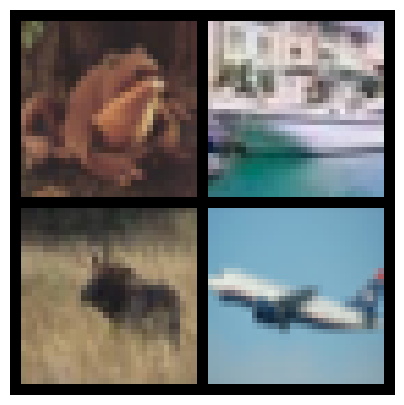

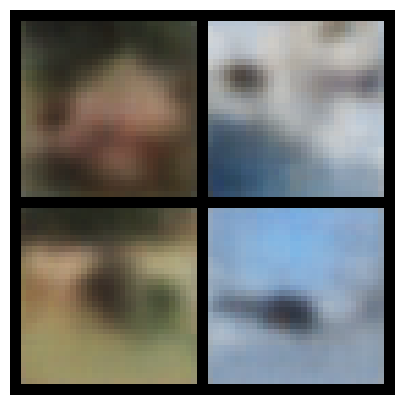

Epoch 26/100: 100%|██████████| 196/196 [00:14<00:00, 13.92it/s, Loss=1.4191, LR=0.000854]


Epoch [26/100] Average Loss: 0.0052 LR: 0.000854


Epoch 27/100: 100%|██████████| 196/196 [00:14<00:00, 13.88it/s, Loss=1.2396, LR=0.000842]


Epoch [27/100] Average Loss: 0.0053 LR: 0.000842


Epoch 28/100: 100%|██████████| 196/196 [00:14<00:00, 13.95it/s, Loss=1.3275, LR=0.000831]


Epoch [28/100] Average Loss: 0.0055 LR: 0.000831


Epoch 29/100: 100%|██████████| 196/196 [00:14<00:00, 13.93it/s, Loss=1.4410, LR=0.000819]


Epoch [29/100] Average Loss: 0.0057 LR: 0.000819


Epoch 30/100: 100%|██████████| 196/196 [00:14<00:00, 13.92it/s, Loss=1.4583, LR=0.000807]


Epoch [30/100] Average Loss: 0.0058 LR: 0.000807


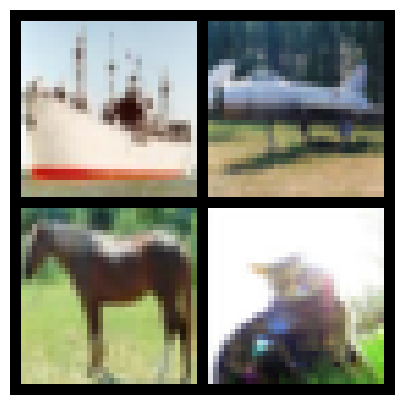

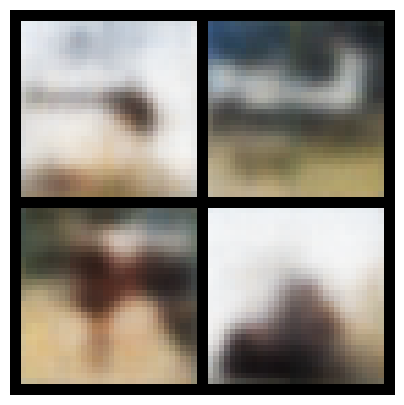

Epoch 31/100: 100%|██████████| 196/196 [00:14<00:00, 13.85it/s, Loss=1.5071, LR=0.000794]


Epoch [31/100] Average Loss: 0.0059 LR: 0.000794


Epoch 32/100: 100%|██████████| 196/196 [00:14<00:00, 13.87it/s, Loss=1.3863, LR=0.000781]


Epoch [32/100] Average Loss: 0.0059 LR: 0.000781


Epoch 33/100: 100%|██████████| 196/196 [00:14<00:00, 13.72it/s, Loss=1.5199, LR=0.000768]


Epoch [33/100] Average Loss: 0.0059 LR: 0.000768


Epoch 34/100: 100%|██████████| 196/196 [00:13<00:00, 14.03it/s, Loss=1.4728, LR=0.000755]


Epoch [34/100] Average Loss: 0.0059 LR: 0.000755


Epoch 35/100: 100%|██████████| 196/196 [00:14<00:00, 13.78it/s, Loss=1.6444, LR=0.000741]


Epoch [35/100] Average Loss: 0.0059 LR: 0.000741


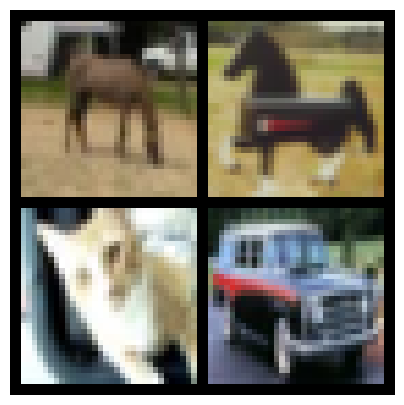

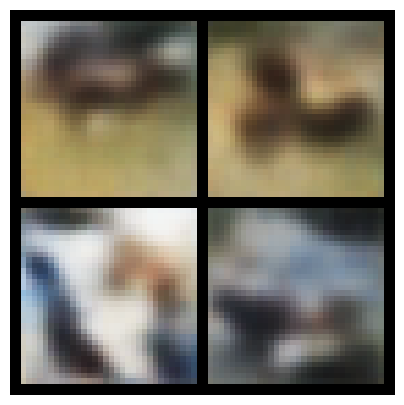

Epoch 36/100: 100%|██████████| 196/196 [00:14<00:00, 13.84it/s, Loss=1.4701, LR=0.000727]


Epoch [36/100] Average Loss: 0.0058 LR: 0.000727


Epoch 37/100: 100%|██████████| 196/196 [00:14<00:00, 13.97it/s, Loss=1.4357, LR=0.000713]


Epoch [37/100] Average Loss: 0.0058 LR: 0.000713


Epoch 38/100: 100%|██████████| 196/196 [00:13<00:00, 14.03it/s, Loss=1.3794, LR=0.000699]


Epoch [38/100] Average Loss: 0.0059 LR: 0.000699


Epoch 39/100: 100%|██████████| 196/196 [00:14<00:00, 13.80it/s, Loss=1.3915, LR=0.000684]


Epoch [39/100] Average Loss: 0.0058 LR: 0.000684


Epoch 40/100: 100%|██████████| 196/196 [00:14<00:00, 13.91it/s, Loss=1.4373, LR=0.000670]


Epoch [40/100] Average Loss: 0.0058 LR: 0.000670


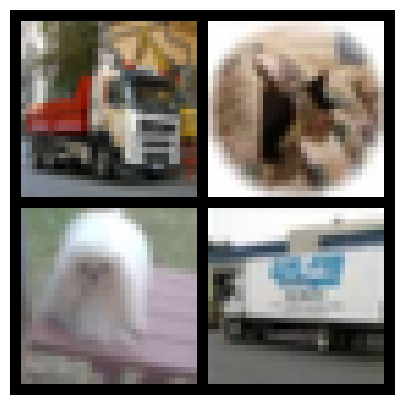

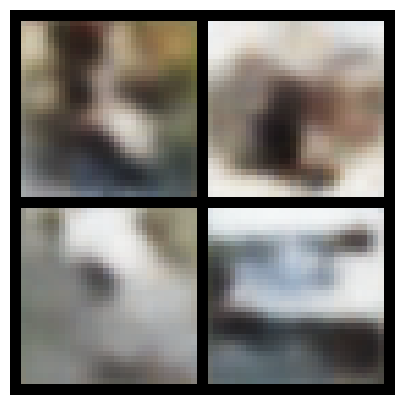

Epoch 41/100: 100%|██████████| 196/196 [00:14<00:00, 13.97it/s, Loss=1.6234, LR=0.000655]


Epoch [41/100] Average Loss: 0.0058 LR: 0.000655


Epoch 42/100: 100%|██████████| 196/196 [00:14<00:00, 13.93it/s, Loss=1.5493, LR=0.000640]


Epoch [42/100] Average Loss: 0.0058 LR: 0.000640


Epoch 43/100: 100%|██████████| 196/196 [00:14<00:00, 13.94it/s, Loss=1.5060, LR=0.000625]


Epoch [43/100] Average Loss: 0.0058 LR: 0.000625


Epoch 44/100: 100%|██████████| 196/196 [00:14<00:00, 13.89it/s, Loss=1.5829, LR=0.000609]


Epoch [44/100] Average Loss: 0.0059 LR: 0.000609


Epoch 45/100: 100%|██████████| 196/196 [00:14<00:00, 13.80it/s, Loss=1.4305, LR=0.000594]


Epoch [45/100] Average Loss: 0.0058 LR: 0.000594


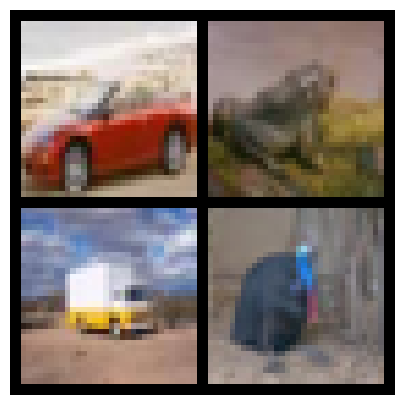

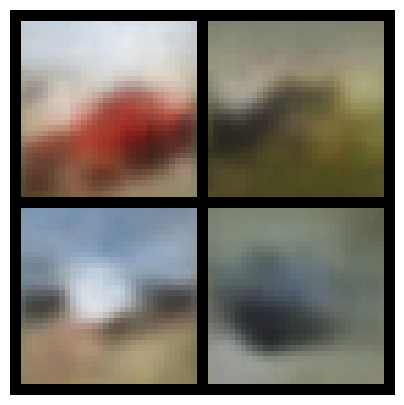

Epoch 46/100: 100%|██████████| 196/196 [00:14<00:00, 13.98it/s, Loss=1.3937, LR=0.000579]


Epoch [46/100] Average Loss: 0.0059 LR: 0.000579


Epoch 47/100: 100%|██████████| 196/196 [00:14<00:00, 13.98it/s, Loss=1.4973, LR=0.000563]


Epoch [47/100] Average Loss: 0.0060 LR: 0.000563


Epoch 48/100: 100%|██████████| 196/196 [00:14<00:00, 13.89it/s, Loss=1.5954, LR=0.000548]


Epoch [48/100] Average Loss: 0.0061 LR: 0.000548


Epoch 49/100: 100%|██████████| 196/196 [00:14<00:00, 13.93it/s, Loss=1.4173, LR=0.000532]


Epoch [49/100] Average Loss: 0.0062 LR: 0.000532


Epoch 50/100: 100%|██████████| 196/196 [00:14<00:00, 13.76it/s, Loss=1.6170, LR=0.000516]


Epoch [50/100] Average Loss: 0.0063 LR: 0.000516


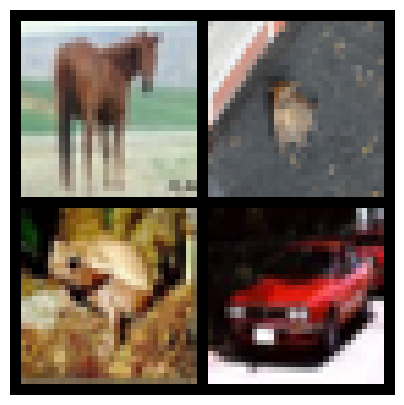

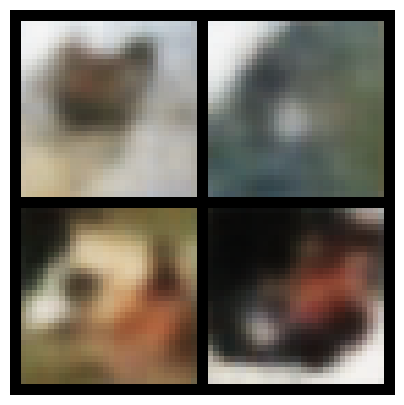

Epoch 51/100: 100%|██████████| 196/196 [00:14<00:00, 13.92it/s, Loss=1.5912, LR=0.000501]


Epoch [51/100] Average Loss: 0.0064 LR: 0.000501


Epoch 52/100: 100%|██████████| 196/196 [00:14<00:00, 13.97it/s, Loss=1.5760, LR=0.000485]


Epoch [52/100] Average Loss: 0.0064 LR: 0.000485


Epoch 53/100: 100%|██████████| 196/196 [00:14<00:00, 13.86it/s, Loss=1.7785, LR=0.000469]


Epoch [53/100] Average Loss: 0.0065 LR: 0.000469


Epoch 54/100: 100%|██████████| 196/196 [00:14<00:00, 13.88it/s, Loss=1.5495, LR=0.000453]


Epoch [54/100] Average Loss: 0.0065 LR: 0.000453


Epoch 55/100: 100%|██████████| 196/196 [00:14<00:00, 13.86it/s, Loss=1.6886, LR=0.000438]


Epoch [55/100] Average Loss: 0.0065 LR: 0.000438


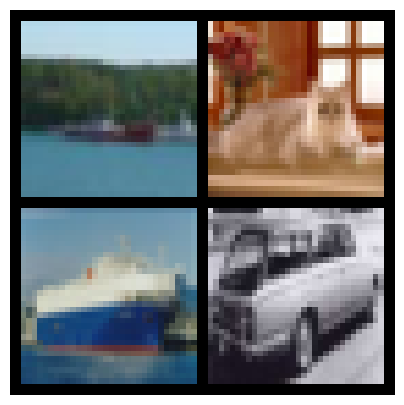

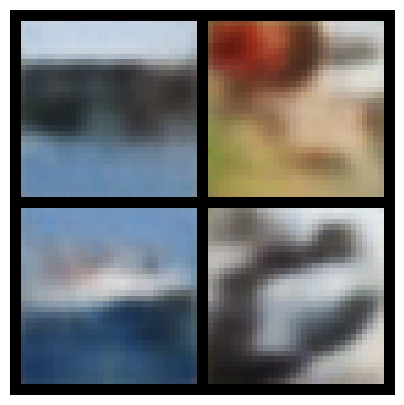

Epoch 56/100: 100%|██████████| 196/196 [00:14<00:00, 13.80it/s, Loss=1.6487, LR=0.000422]


Epoch [56/100] Average Loss: 0.0065 LR: 0.000422


Epoch 57/100: 100%|██████████| 196/196 [00:14<00:00, 13.93it/s, Loss=1.5930, LR=0.000407]


Epoch [57/100] Average Loss: 0.0066 LR: 0.000407


Epoch 58/100: 100%|██████████| 196/196 [00:14<00:00, 13.87it/s, Loss=1.7310, LR=0.000392]


Epoch [58/100] Average Loss: 0.0066 LR: 0.000392


Epoch 59/100:  52%|█████▏    | 102/196 [00:07<00:06, 14.05it/s, Loss=1.7298, LR=0.000376]

In [ ]:

# Training Loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    # Use tqdm for the progress bar
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}')

    for batch_idx, (data, _) in pbar:
        data = data.to(device)

        optimizer.zero_grad()
        recon_batch, vq_loss = model(data)
        loss = vqvae_loss(recon_batch, data, vq_loss)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        # Update tqdm description with current loss and learning rate
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'LR': f'{current_lr:.6f}'
        })

    # Step the scheduler after each epoch
    scheduler.step()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch + 1}/{num_epochs}] Average Loss: {avg_loss:.4f} LR: {current_lr:.6f}')

    # Save and display a sample of the reconstructed images
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            recon_batch, _ = model(data)
            show_image(data.cpu())
            show_image(recon_batch.cpu())